# Predicting Shape of Linear Elastic Bar
Linear Elastic Bar Obeys:
$$\frac{d}{dx}\left(EA\frac{du}{dx}\right)+p=0$$

We solve this for the case where:
$$p(x)=4\pi^2\sin(2\pi x)$$
And $u(0)=u(1)=0$

We compare this to the analytic solution:
$$u(x)=\sin(2\pi x)$$



In [1]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

def print_train_time(start: float, end: float, device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [3]:
# The code in this block is taken from Deep Learning in Computational Mechanics, S. Kollmannsberger et al. 2021

def buildModel(input_dim, hidden_dim, output_dim):
  model = torch.nn.Sequential(torch.nn.Linear(input_dim, hidden_dim), torch.nn.Tanh(), torch.nn.Linear(hidden_dim, output_dim))
  return model

def get_derivative(y,x):
  dydx = torch.autograd.grad(y, x, torch.ones(x.size()[0], 1), create_graph=True, retain_graph=True)[0]
  return dydx

def f(model, x, EA, p):
  u = model(x)
  u_x = get_derivative(u, x)
  EAu_xx = get_derivative(EA(x) * u_x, x)
  f = EAu_xx + p(x)
  return f

# Training
I tried with SQD, Adam and L-BFGS Optimizers and found, at best, that they converged after 2000, 500 and 30 epochs, respectively.

  0%|          | 0/40 [00:00<?, ?it/s]

Train time on cpu: 17.041 seconds


Text(0.5, 0, 'epochs')

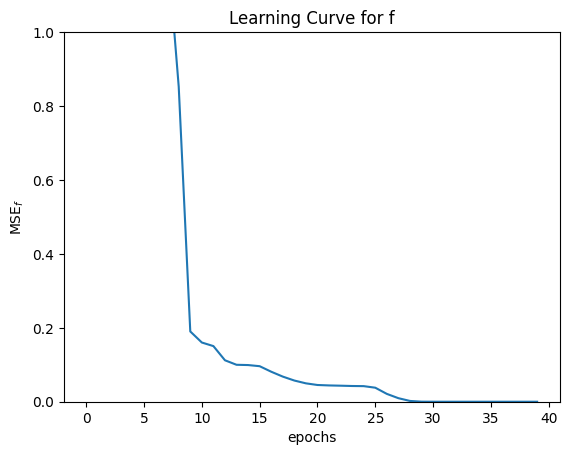

In [4]:
model = buildModel(1, 10, 1)
model.to(device)
x = torch.linspace(0, 1, 10, requires_grad=True).view(-1, 1)
EA = lambda x: 1 + 0 * x
p = lambda x: 4 * math.pi**2 * torch.sin(2 * math.pi * x)

train_time_start_on_gpu = timer()
epochs = 40
optimizer = torch.optim.LBFGS(params=model.parameters(), lr=0.1)

model.to(device)
f_conv = np.zeros(epochs)
b_conv = np.zeros(epochs)

def closure():
  # Compute u, f
    u_pred = model(x)
    f_pred = f(model, x, EA, p)
    #print(f"u_pred = {u_pred}")
    #print(f"f_pred = {f_pred}")
    # Boundary conditions
    u0 = 0
    u1 = 0
    u0_pred = model(torch.tensor([0.]))
    u1_pred = model(torch.tensor([1.]))
    # Compute loss
    MSE_f = torch.sum(f_pred**2)
    MSE_b = (u0_pred - u0)**2 + (u1_pred - u1)**2
    loss = MSE_f + 50*MSE_b
    #train_loss[epoch] = loss.item()
    f_conv[epoch] = MSE_f.item()
    #b_conv[epoch] = MSE_b.item()
    optimizer.zero_grad()
    loss.backward()
    return loss

model.train()
for epoch in tqdm(range(epochs)):
  optimizer.step(closure)
  #print(f"MSE_f: {MSE_f}, MSE_b: {MSE_b}")
  #print(f"Loss: {loss[0]}")
#print(train_loss)
train_time_end_on_gpu = timer()
total_train_time = print_train_time(start=train_time_start_on_gpu, end=train_time_end_on_gpu, device=device)
plt.plot(np.arange(0,epochs),f_conv)
plt.ylim(0,1)
plt.title("Learning Curve for f")
plt.ylabel(r"$\text{MSE}_f$")
plt.xlabel("epochs")

Text(0, 0.5, 'u')

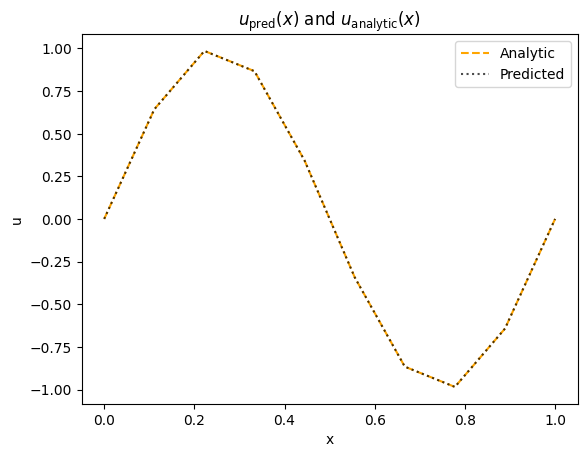

In [5]:
def true_func(x): return torch.sin(2*torch.pi*x)

plt.plot(x.detach().numpy(),true_func(x).detach().numpy(), label="Analytic",linestyle='dashed',c='orange')
plt.plot(x.detach().numpy(), model(x).detach().numpy(), label="Predicted",linestyle='dotted',c='black',alpha=0.7)
plt.legend()
plt.title(r"$u_{\text{pred}}(x)$ and $u_{\text{analytic}}(x)$")
plt.xlabel('x')
plt.ylabel('u')